# Brain Tumors Object Detection using YOLOv8


> Brain tumors present a major diagnostic problem in medicine, requiring effective and precise detection methods. In this work, we use the YOLOv8 deep learning model to identify and locate brain cancers in MRI images. The dataset, which was obtained via Kaggle, includes bounding box annotations on MRI images, allowing for object detection-based classification. Our method entails pre-processing MRI scans, optimizing the YOLOv8 model, and assessing its effectiveness using common measures like recall, precision, and mAP (mean average precision). The model can detect and categorize cancers properly in real-time with high confidence scores, according to experimental results. YOLOv8 is a promising option for automated tumor screening since it provides a quicker and more reliable detection process than conventional convolutional neural networks (CNNs). The possibilities of deep learning in medical imaging are demonstrated by this study, which also opens the door for the incorporation of object detection models into clinical procedures.

# Imports & Setup

In [2]:
import os
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

# Explore Classes

In [3]:
train_dir = "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train"
test_dir = "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val"
categories = os.listdir(train_dir)
print("Classes:", categories)

Classes: ['Pituitary', 'No Tumor', 'Meningioma', 'Glioma']


# Sample Images

Train images


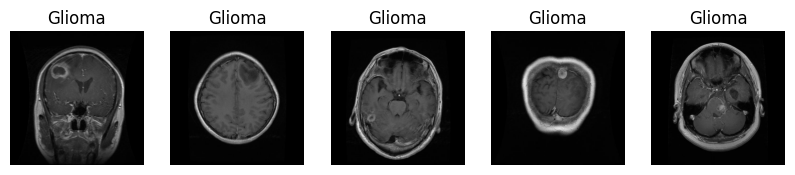

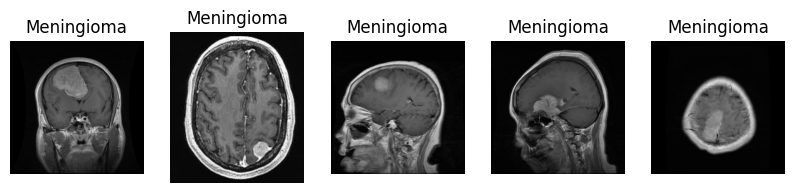

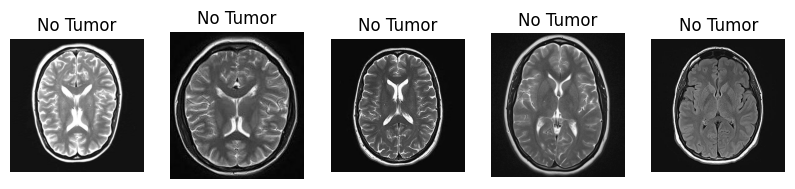

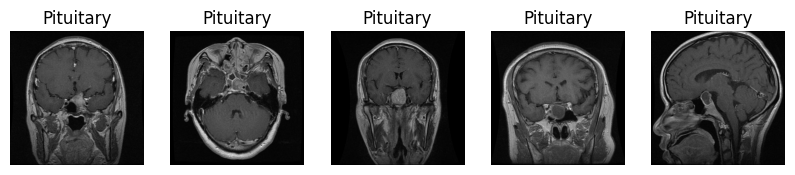

Validation Images


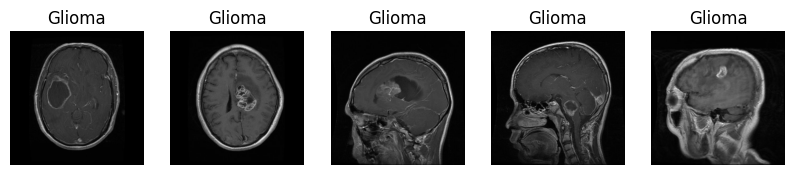

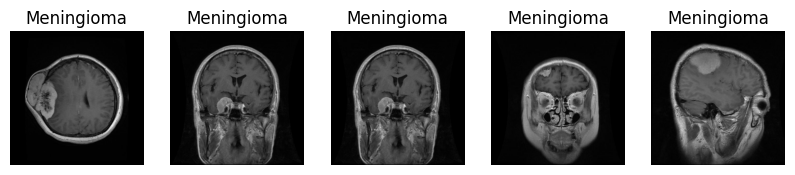

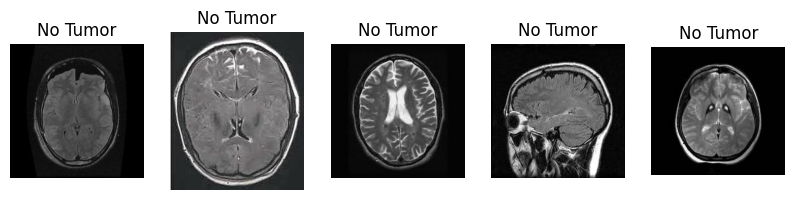

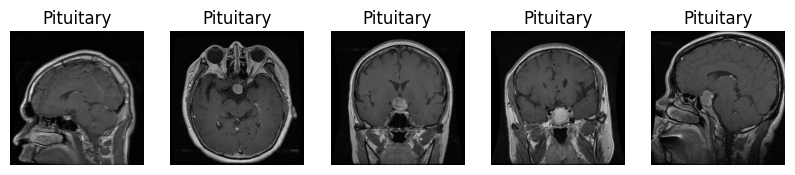

In [4]:
import os
import cv2

classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
def sample_images(folder_path, num_samples = 5):
    for i in range(0,4):
        folder_path_final = os.path.join(folder_path,classes[i],'images')
        images = os.listdir(folder_path_final)
        sample_images = images[:num_samples]
        plt.figure(figsize=(10, 10))
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(folder_path_final, img_name)
            img = cv2.imread(img_path)
            
            plt.subplot(1, num_samples, j+1)
            plt.imshow(img)
            plt.title(classes[i])
            plt.axis("off")
    
        plt.show()
print("Train images")
sample_images(train_dir)
print("Validation Images")
sample_images(test_dir)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


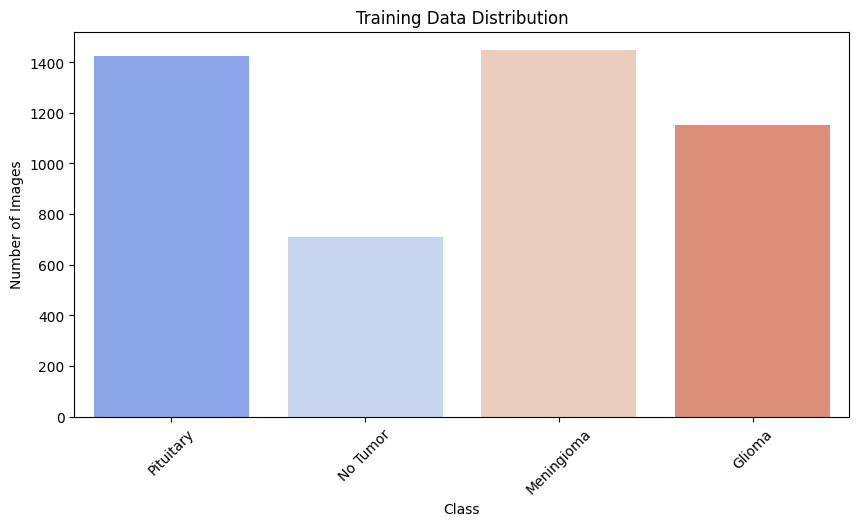

In [5]:
import seaborn as sns

# Count images per class
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls, "images"))) for cls in categories}

# Plot distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Training Data Distribution")
plt.show()


# Visualize Bounding Boxes

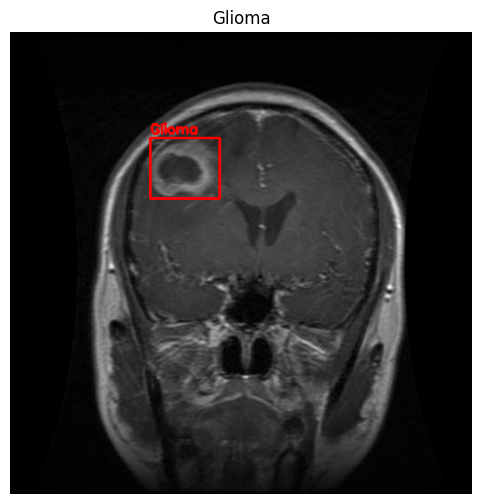

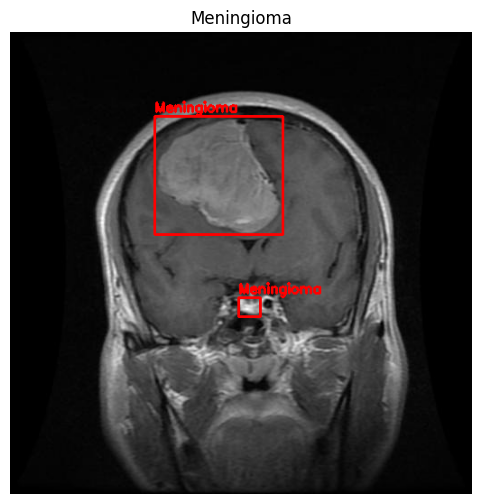

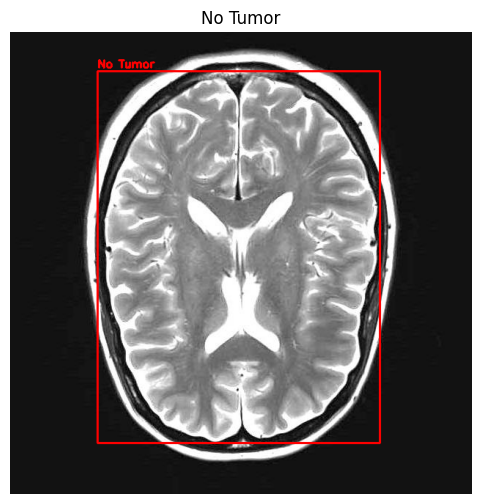

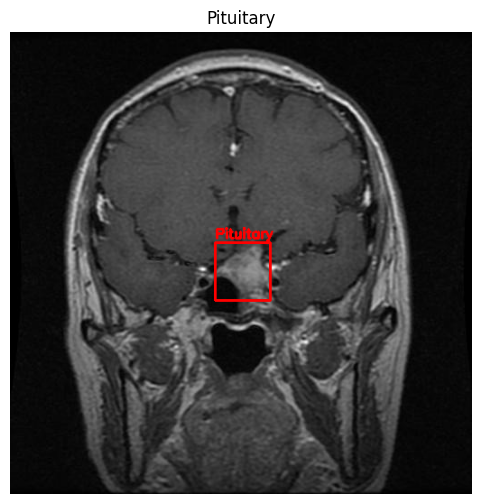

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

dataset_path = "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train"
classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

def visualize_bounding_boxes(class_name, img_name):
    img_path = os.path.join(dataset_path, class_name, "images", img_name)
    label_path = os.path.join(dataset_path, class_name, "labels", img_name.replace(".jpg", ".txt"))
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    
    
    h, w, _ = image.shape

    if os.path.exists(label_path):
        with open(label_path, "r") as file:
            lines = file.readlines()

        for line in lines:
            values = list(map(float, line.strip().split()))
            class_id, x_center, y_center, box_width, box_height = values

            
            x1 = int((x_center - box_width / 2) * w)
            y1 = int((y_center - box_height / 2) * h)
            x2 = int((x_center + box_width / 2) * w)
            y2 = int((y_center + box_height / 2) * h)

            
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  
            cv2.putText(image, class_name, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(class_name)
    plt.show()

for class_name in classes:
    sample_image = os.listdir(os.path.join(dataset_path, class_name, "images"))[0]  # Pick first image
    visualize_bounding_boxes(class_name, sample_image)


# Dataset Restructure for YOLO Training

In [7]:
import os
import shutil

dataset_path = "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes"
output_path = "/kaggle/working/yolo_mri"

for split in ["Train", "Val"]:
    for folder in ["images", "labels"]:
        os.makedirs(os.path.join(output_path, folder, split.lower()), exist_ok=True)

    for tumor_type in ["Glioma", "Meningioma", "No Tumor", "Pituitary"]:
        image_dir = os.path.join(dataset_path, split, tumor_type, "images")
        label_dir = os.path.join(dataset_path, split, tumor_type, "labels")

        output_image_dir = os.path.join(output_path, "images", split.lower())
        output_label_dir = os.path.join(output_path, "labels", split.lower())

        for image_name in os.listdir(image_dir):
            if image_name.endswith(".jpg"):
                image_base = os.path.splitext(image_name)[0]  
                label_file = None
         
                for label_name in os.listdir(label_dir):
                    if image_base in label_name and label_name.endswith(".txt"):
                        label_file = label_name
                        break

                if label_file:
                    shutil.copy(os.path.join(image_dir, image_name), os.path.join(output_image_dir, image_name))
                    shutil.copy(os.path.join(label_dir, label_file), os.path.join(output_label_dir, label_file))
                else:
                    print(f"No label found for {image_name}, skipping.")

print("Dataset restructured for YOLO training!")


No label found for image(61).jpg, skipping.
No label found for image(55).jpg, skipping.
Dataset restructured for YOLO training!


# Create data.yaml

In [8]:
yaml_content = """train: /kaggle/working/yolo_mri/images/train
val: /kaggle/working/yolo_mri/images/val

nc: 4
names: ["Glioma", "Meningioma", "No Tumor", "Pituitary"]
"""

# Ensure the directory exists
os.makedirs("/kaggle/working/yolo_mri", exist_ok=True)

# Save the data.yaml file
with open("/kaggle/working/yolo_mri/data.yaml", "w") as f:
    f.write(yaml_content)

print("data.yaml created successfully!")


data.yaml created successfully!


# Count Images and Labels

In [9]:
import os

# Define dataset paths
image_train_path = "/kaggle/working/yolo_mri/images/train"
image_val_path = "/kaggle/working/yolo_mri/images/val"
label_train_path = "/kaggle/working/yolo_mri/labels/train"
label_val_path = "/kaggle/working/yolo_mri/labels/val"

# Count images and labels
num_train_images = len([f for f in os.listdir(image_train_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
num_val_images = len([f for f in os.listdir(image_val_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
num_train_labels = len([f for f in os.listdir(label_train_path) if f.endswith('.txt')])
num_val_labels = len([f for f in os.listdir(label_val_path) if f.endswith('.txt')])

# Print results
print(f"Training Images: {num_train_images}, Training Labels: {num_train_labels}")
print(f"Validation Images: {num_val_images}, Validation Labels: {num_val_labels}")


Training Images: 4737, Training Labels: 4729
Validation Images: 510, Validation Labels: 510


# Report missing Images/Labels & empty label

In [10]:
train_images = {f.split('.')[0] for f in os.listdir(image_train_path) if f.endswith(('.jpg', '.png', '.jpeg'))}
train_labels = {f.split('.')[0] for f in os.listdir(label_train_path) if f.endswith('.txt')}

missing_labels = train_images - train_labels
missing_images = train_labels - train_images

print(f"Images without labels: {len(missing_labels)} → {missing_labels}")
print(f"Labels without images: {len(missing_images)} → {missing_images}")


Images without labels: 8 → {'6', '1', '3', '4', '8', '7', 'image', '5'}
Labels without images: 0 → set()


In [11]:
for label_file in os.listdir(label_train_path):
    label_path = os.path.join(label_train_path, label_file)
    if os.path.getsize(label_path) == 0:  
        print(f"Empty label file: {label_file}")


# Remove unmatched images

In [12]:
import os


image_train_path = "/kaggle/working/yolo_mri/images/train"
label_train_path = "/kaggle/working/yolo_mri/labels/train"

image_val_path = "/kaggle/working/yolo_mri/images/val"
label_val_path = "/kaggle/working/yolo_mri/labels/val"

def remove_unmatched_images(image_path, label_path):
    image_files = {f.split('.')[0] for f in os.listdir(image_path) if f.endswith(('.jpg', '.png', '.jpeg'))}
    label_files = {f.split('.')[0] for f in os.listdir(label_path) if f.endswith('.txt')}

    missing_labels = image_files - label_files  

    for img_name in missing_labels:
        for ext in ['.jpg', '.png', '.jpeg']:  
            img_file = os.path.join(image_path, img_name + ext)
            if os.path.exists(img_file):
                os.remove(img_file)
                print(f"Removed: {img_file}")


remove_unmatched_images(image_train_path, label_train_path)
remove_unmatched_images(image_val_path, label_val_path)

print("Cleanup complete! All images without labels are removed.")


Removed: /kaggle/working/yolo_mri/images/train/6.jpg
Removed: /kaggle/working/yolo_mri/images/train/1.jpg
Removed: /kaggle/working/yolo_mri/images/train/3.jpg
Removed: /kaggle/working/yolo_mri/images/train/4.jpg
Removed: /kaggle/working/yolo_mri/images/train/8.jpg
Removed: /kaggle/working/yolo_mri/images/train/7.jpg
Removed: /kaggle/working/yolo_mri/images/train/image.jpg
Removed: /kaggle/working/yolo_mri/images/train/5.jpg
Cleanup complete! All images without labels are removed.


# Count images and label after cleanup

In [13]:
import os


image_train_path = "/kaggle/working/yolo_mri/images/train"
image_val_path = "/kaggle/working/yolo_mri/images/val"
label_train_path = "/kaggle/working/yolo_mri/labels/train"
label_val_path = "/kaggle/working/yolo_mri/labels/val"

num_train_images = len([f for f in os.listdir(image_train_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
num_val_images = len([f for f in os.listdir(image_val_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
num_train_labels = len([f for f in os.listdir(label_train_path) if f.endswith('.txt')])
num_val_labels = len([f for f in os.listdir(label_val_path) if f.endswith('.txt')])

# Print results
print(f"Training Images: {num_train_images}, Training Labels: {num_train_labels}")
print(f"Validation Images: {num_val_images}, Validation Labels: {num_val_labels}")


Training Images: 4729, Training Labels: 4729
Validation Images: 510, Validation Labels: 510


# Train YOLOv8

In [14]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.5/983.5 kB 18.2 MB/s eta 0:00:00a 0:00:01


In [15]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [16]:
model = YOLO("yolov8s.pt")  # Use the YOLOv8 small model (you can use yolov8m.pt or yolov8l.pt)
results = model.train(data="/kaggle/working/yolo_mri/data.yaml", epochs=50, imgsz=640)

100%|██████████| 21.5M/21.5M [00:00<00:00, 159MB/s]


Ultralytics 8.3.115 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/yolo_mri/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_widt

100%|██████████| 755k/755k [00:00<00:00, 17.3MB/s]
2025-04-24 12:07:45,385	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-24 12:07:46,240	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 72.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 824.5±334.2 MB/s, size: 26.9 KB)


train: Scanning /kaggle/working/yolo_mri/labels/train... 4729 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4729/4729 [00:03<00:00, 1411.39it/s]


train: New cache created: /kaggle/working/yolo_mri/labels/train.cache
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 446.2±115.2 MB/s, size: 20.6 KB)


val: Scanning /kaggle/working/yolo_mri/labels/val... 510 images, 1 backgrounds, 0 corrupt: 100%|██████████| 510/510 [00:00<00:00, 1308.79it/s]


val: New cache created: /kaggle/working/yolo_mri/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       3.8G      1.061      1.806      1.251         15        640: 100%|██████████| 296/296 [01:13<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.02it/s]

                   all        510        554      0.725      0.598      0.681      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.56G      1.061      1.089      1.244         15        640: 100%|██████████| 296/296 [01:13<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]

                   all        510        554      0.825       0.79      0.863      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.58G      1.066      1.046      1.237         16        640: 100%|██████████| 296/296 [01:13<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]

                   all        510        554      0.763      0.688      0.751      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.58G      1.032      0.958      1.223         16        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]

                   all        510        554      0.805      0.734      0.827      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.58G      1.003     0.8791      1.205         17        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.75it/s]

                   all        510        554      0.846      0.847      0.877      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.58G     0.9645     0.8258      1.175         19        640: 100%|██████████| 296/296 [01:13<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.76it/s]

                   all        510        554       0.85      0.861      0.913      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.58G     0.9481      0.774      1.164         11        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]

                   all        510        554      0.893      0.793      0.891      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.58G     0.9313     0.7382      1.153         21        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]

                   all        510        554      0.902      0.839      0.928      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.58G     0.9247     0.7418      1.151         14        640: 100%|██████████| 296/296 [01:12<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.78it/s]

                   all        510        554      0.902      0.862      0.932      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.58G     0.9092     0.7084      1.139         13        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.78it/s]

                   all        510        554      0.896      0.902      0.945      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.58G     0.9038     0.6868       1.14         15        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.80it/s]

                   all        510        554      0.909      0.853      0.921      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.58G     0.8805     0.6635      1.121         19        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]

                   all        510        554      0.898      0.896       0.94      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.58G     0.8718     0.6391      1.118         18        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.77it/s]

                   all        510        554      0.908      0.861       0.93       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.58G      0.873     0.6417      1.122         15        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.76it/s]

                   all        510        554      0.943      0.898      0.948      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.58G     0.8582     0.6076      1.107         16        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.80it/s]

                   all        510        554      0.939      0.874      0.945      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.58G     0.8433     0.6032      1.109         13        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.76it/s]

                   all        510        554      0.923      0.908      0.951      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.58G     0.8389     0.5889      1.097         16        640: 100%|██████████| 296/296 [01:12<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.79it/s]

                   all        510        554      0.931      0.898      0.951      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.58G     0.8355      0.579      1.101         18        640: 100%|██████████| 296/296 [01:12<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.78it/s]

                   all        510        554       0.95      0.906      0.956      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.58G     0.8327     0.5792      1.097         20        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]

                   all        510        554      0.932      0.912      0.955      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.58G     0.8147     0.5597      1.092         18        640: 100%|██████████| 296/296 [01:12<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.80it/s]

                   all        510        554      0.912        0.9       0.95       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.58G     0.8076     0.5585      1.084         20        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.79it/s]

                   all        510        554      0.926      0.931      0.965      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.58G     0.7959     0.5297      1.078         12        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]

                   all        510        554      0.943      0.907      0.957      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.58G     0.8001     0.5369      1.076         18        640: 100%|██████████| 296/296 [01:12<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.77it/s]

                   all        510        554      0.922      0.928      0.956      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.58G     0.8005     0.5255      1.074         16        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]

                   all        510        554      0.962      0.907      0.964      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.58G     0.7883     0.5157      1.071         18        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.75it/s]

                   all        510        554      0.941      0.921      0.965      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.58G     0.7867     0.5109      1.067         16        640: 100%|██████████| 296/296 [01:13<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.61it/s]

                   all        510        554      0.931       0.93      0.965      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.58G      0.767     0.4991      1.056         13        640: 100%|██████████| 296/296 [01:13<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]

                   all        510        554       0.96      0.918      0.962      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.58G     0.7664     0.4905      1.065         16        640: 100%|██████████| 296/296 [01:13<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.79it/s]

                   all        510        554      0.944      0.934      0.965      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.58G     0.7593     0.4883       1.06         19        640: 100%|██████████| 296/296 [01:13<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]

                   all        510        554      0.947      0.921       0.96       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.58G      0.773     0.4855      1.065         22        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.81it/s]

                   all        510        554      0.966      0.907      0.965      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.58G     0.7408     0.4717      1.053         15        640: 100%|██████████| 296/296 [01:13<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.78it/s]

                   all        510        554      0.941      0.954      0.967      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.58G     0.7388     0.4551      1.043         18        640: 100%|██████████| 296/296 [01:12<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.81it/s]

                   all        510        554      0.956      0.919      0.969      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.58G     0.7444     0.4607      1.049         28        640: 100%|██████████| 296/296 [01:13<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]

                   all        510        554       0.95      0.923      0.966      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.58G     0.7377     0.4515      1.048         16        640: 100%|██████████| 296/296 [01:13<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.74it/s]

                   all        510        554      0.954      0.938      0.969      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.58G     0.7334     0.4459      1.042         14        640: 100%|██████████| 296/296 [01:13<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.76it/s]

                   all        510        554      0.937      0.952      0.965      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.58G     0.7195     0.4326      1.038         19        640: 100%|██████████| 296/296 [01:13<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.80it/s]

                   all        510        554      0.968      0.932      0.965      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.58G     0.7186     0.4373      1.038         25        640: 100%|██████████| 296/296 [01:13<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.79it/s]

                   all        510        554      0.949      0.943      0.965       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.58G     0.7127     0.4217      1.029         14        640: 100%|██████████| 296/296 [01:13<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]

                   all        510        554      0.972      0.925      0.965      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.58G     0.7111      0.417      1.032         19        640: 100%|██████████| 296/296 [01:13<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]

                   all        510        554      0.956      0.907      0.963      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.58G      0.701     0.4107       1.03         17        640: 100%|██████████| 296/296 [01:13<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.77it/s]

                   all        510        554      0.959      0.932      0.964      0.796


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.58G     0.6533     0.3581     0.9941         10        640: 100%|██████████| 296/296 [01:13<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.76it/s]

                   all        510        554      0.939      0.957      0.966      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.58G      0.649     0.3504     0.9914         11        640: 100%|██████████| 296/296 [01:12<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]

                   all        510        554      0.941      0.949      0.966      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.58G     0.6424     0.3396     0.9872         10        640: 100%|██████████| 296/296 [01:12<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.76it/s]

                   all        510        554      0.954      0.943      0.969      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.58G     0.6285     0.3304     0.9777          9        640: 100%|██████████| 296/296 [01:12<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.75it/s]

                   all        510        554      0.962      0.934      0.969      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.58G     0.6233      0.327     0.9776          9        640: 100%|██████████| 296/296 [01:12<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]

                   all        510        554      0.971      0.924      0.966      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.58G     0.6115     0.3201     0.9714          9        640: 100%|██████████| 296/296 [01:12<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.76it/s]

                   all        510        554      0.938      0.958      0.967      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.58G     0.6081     0.3084     0.9678          9        640: 100%|██████████| 296/296 [01:12<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.79it/s]

                   all        510        554      0.949      0.949      0.968      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.58G     0.6045     0.3076     0.9626         11        640: 100%|██████████| 296/296 [01:12<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.80it/s]

                   all        510        554      0.961      0.933      0.966      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.58G     0.5939     0.3028     0.9568         10        640: 100%|██████████| 296/296 [01:12<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.79it/s]

                   all        510        554      0.969      0.925      0.966      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.58G     0.5932     0.2999     0.9587         10        640: 100%|██████████| 296/296 [01:12<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]

                   all        510        554      0.955       0.94      0.968      0.808



50 epochs completed in 1.079 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.115 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]


                   all        510        554      0.949      0.949      0.968       0.81
                Glioma        135        153       0.89      0.922       0.94      0.772
            Meningioma        140        142      0.986      0.997      0.994      0.851
              No Tumor         98         98          1      0.979      0.995      0.855
             Pituitary        154        161      0.922      0.901      0.943       0.76
Speed: 0.2ms preprocess, 4.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


# Show Training Results

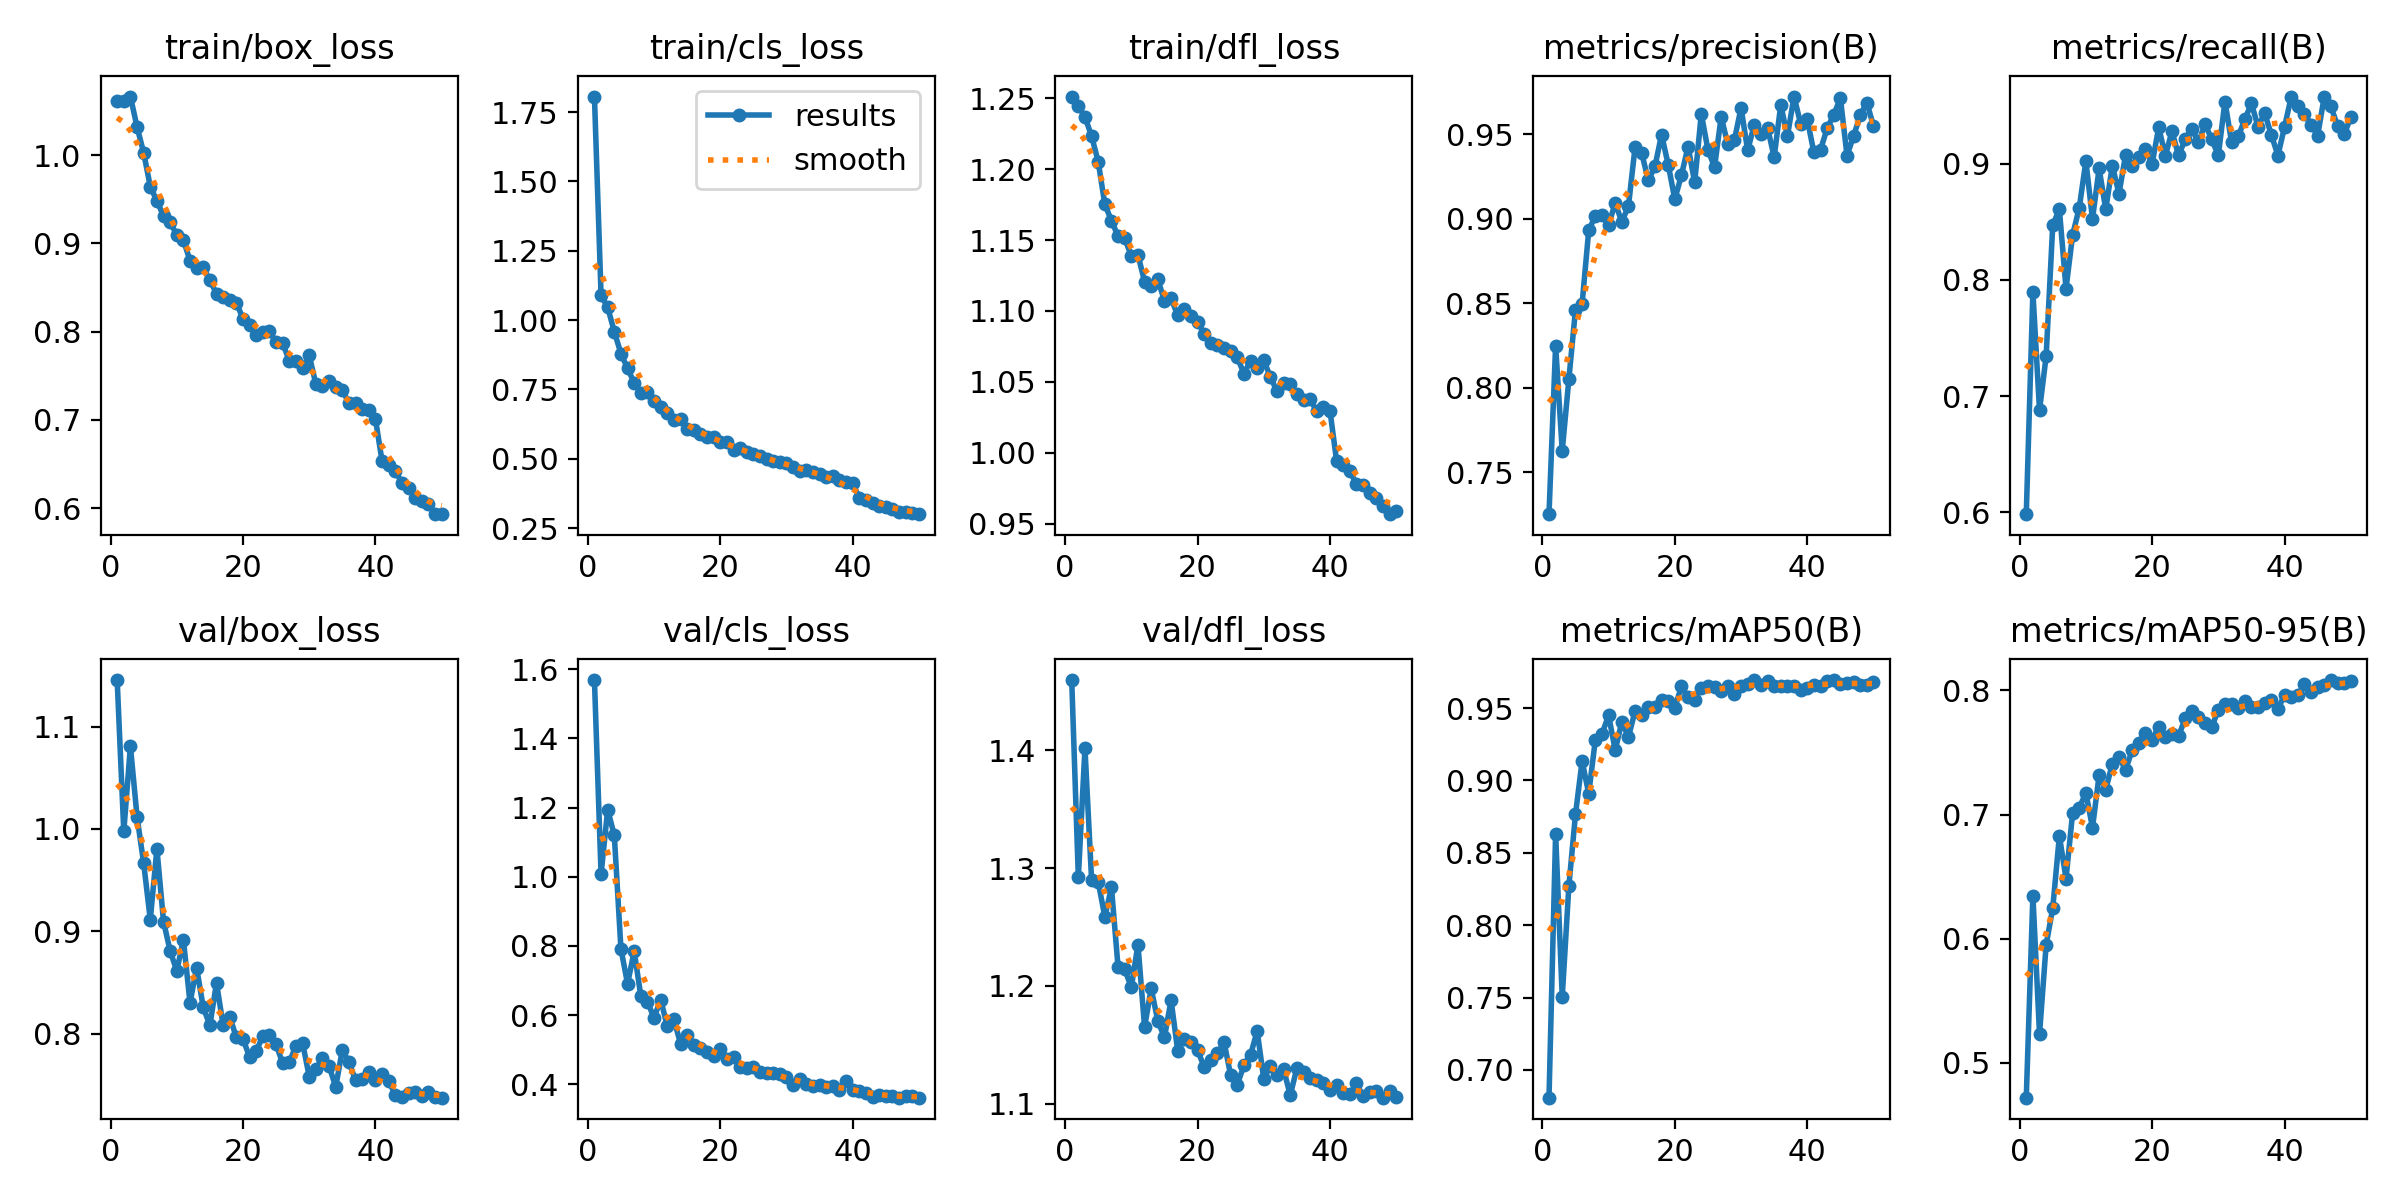

In [17]:
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Show results
display(Image(filename="runs/detect/train/results.png"))


# END